# Logistic model fitting using Sequential Monte Carlo

This example illustrates how to use SMC to sample from a posterior distribution for the logistic model, with normal errors. This example also indicates how it is typically necessary to tune hyperparameters to ensure good algorithmic performance on a given problem.

In [1]:
from __future__ import print_function
import os
os.chdir('..')
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [-5, 400, noise*0.1],
    [5, 600, noise*100]
)

In [2]:
sigma0 = [[  2.91011771e-10,  -2.36999772e-06,   3.10373379e-07],
       [ -2.36999772e-06,   2.01671027e-01,  -7.21897714e-03],
       [  3.10373379e-07,  -7.21897714e-03,   2.98319257e-02]]


# Create mcmc routine
smc = pints.SMCController(log_likelihood, log_prior, sigma0)

# Set number of particles
smc.sampler().set_n_particles(5000)

# Run sampler
samples = smc.run()

/home/michael/dev/pints/pints/toy/_logistic_model.py:70: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
/home/michael/dev/pints/pints/toy/_logistic_model.py:73: RuntimeWarning: overflow encountered in multiply
  values = k / (1 + c * exp)


Using Sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Number of MCMC steps at each temperature: 1
Running in sequential mode.
Iter. Eval. Temperature ESS       Acc.      Time m:s
0     5000   0.9999      4502.912  0          0:00.7


/home/michael/dev/pints/pints/_log_likelihoods.py:476: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))
/home/michael/dev/pints/pints/_sequential/_SMC.py:252: RuntimeWarning: divide by zero encountered in log
  self._weights[j] = np.log(w) + self._w_tilde(


1     10000  0.99972     4377.179  0.233      0:03.6
2     15000  0.99923     4076.151  0.233      0:06.1
3     20000  0.99785     2134.997  0.23       0:08.6
Resampling ess threshold
4     25000  0.99401     102.0413  0.226      0:11.1
Resampling ess threshold
5     30000  0.98332     3712.286  0.199872   0:13.9
6     35000  0.95358     3526.779  0.188      0:16.4
7     40000  0.87085     1.23814   0.178      0:18.9
Resampling ess threshold
8     45000  0.64062     4488.388  0.163      0:21.5
9     50000  0           1.288112  0.199      0:24.0


## Plot results

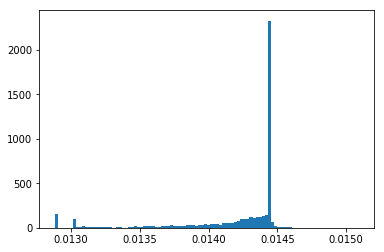

1.2881119937378507


In [3]:
plt.hist(samples[:, 0], 100)
plt.show()
print(smc.sampler().ess())

In [4]:
# Goodwin model

from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.GoodwinOscillatorModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = model.suggested_times()
org_values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, org_values)

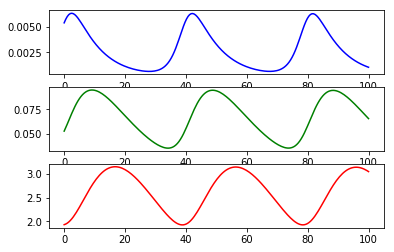

In [5]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, org_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, org_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, org_values[:, 2], 'r')
plt.show()

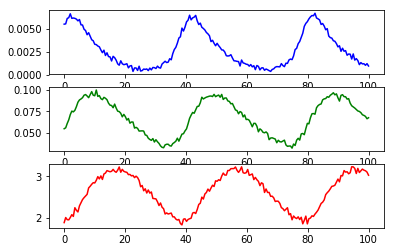

In [6]:
noise1 = 0.0002
noise2 = 0.002
noise3 = 0.05
noisy_values = np.array(org_values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

In [7]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])


In [8]:
# Create mcmc routine
smc = pints.SMCController(log_likelihood, log_prior)

# Set number of particles
smc.sampler().set_n_particles(1000)

# Run sampler
samples = smc.run()

Using Sequential Monte Carlo
Total number of particles: 1000
Number of temperatures: 10
Number of MCMC steps at each temperature: 1
Running in sequential mode.
Iter. Eval. Temperature ESS       Acc.      Time m:s
0     1000   0.9999      7.759888  0          0:12.4
Resampling ess threshold


/home/michael/dev/pints/pints/toy/_goodwin_oscillator_model.py:44: RuntimeWarning: overflow encountered in double_scalars
  dxdt = 1 / (1 + z**10) - m1 * x


1     2000   0.99972     743.2821  0.196      0:19.1
2     3000   0.99923     30.29366  0.17991    0:25.4
Resampling ess threshold
3     4000   0.99785     174.5681  0.172      0:31.5
Resampling ess threshold
4     5000   0.99401     9.101732  0.194      0:37.3
Resampling ess threshold
5     6000   0.98332     23.26701  0.214      0:41.8
Resampling ess threshold
6     7000   0.95358     25.22309  0.241793   0:46.1
Resampling ess threshold
7     8000   0.87085     2.184018  0.25025    0:50.5
Resampling ess threshold
8     9000   0.64062     967.0892  0.258      0:54.8


/home/michael/dev/pints/pints/_sequential/_SMC.py:344: RuntimeWarning: invalid value encountered in double_scalars
  return beta * fx + (1 - beta) * f_prior


9     10000  0           1         0.267      0:59.1


<Figure size 432x288 with 0 Axes>

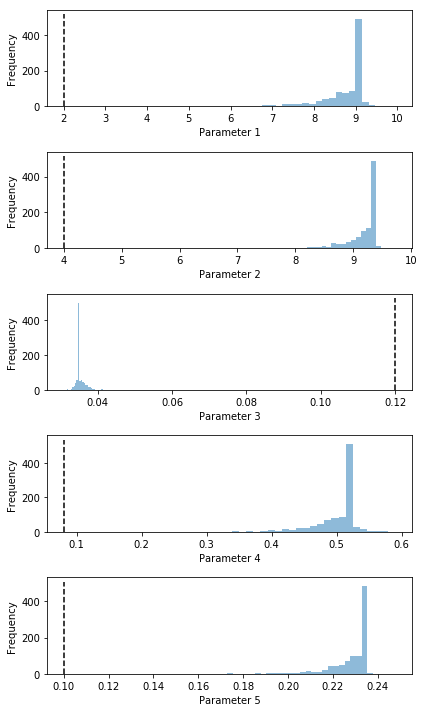

In [9]:
plt.figure()
pints.plot.histogram([samples], real_parameters)
plt.show()

<Figure size 432x288 with 0 Axes>

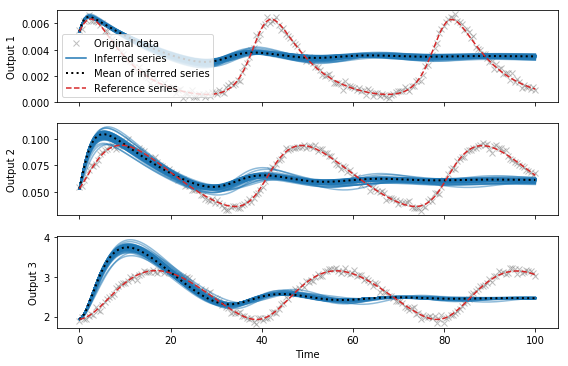

In [10]:
plt.figure()
pints.plot.series(samples, problem, real_parameters)
plt.show()